
AYTEKİN YILDIZHAN

**Task – Recommender Design:**

Dataset : Dataset : http://ai.stanford.edu/~amaas/data/sentiment/

* 1- Create a dataframe with following schema: 
    
    root 
        |-- content: string (nullable = true) 
        |-- label: string (nullable = true) 
        |-- sentiment: string (nullable = true)
            
* 2- Design a tokenizer for content column and remove stop words, and give descriptive information about obtained content column
____

# THIRD QUESTION
* 1- Create a dataframe with following schema: 
    
    root 
        |-- content: string (nullable = true) 
        |-- label: string (nullable = true) 
        |-- sentiment: string (nullable = true)
_______

In [2]:
# HERE IS OUR LIBRARIES THAT WE USE

In [4]:
import sys
import os
import pandas as pd
import sqlalchemy
import numpy as np
import pyprind

from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Flatten, Dropout, Lambda
from keras.layers.embeddings import Embedding
import tensorflow as tf
from tensorflow.keras import losses

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import text_to_word_sequence

from keras.utils import tf_inspect
from keras.utils.generic_utils import Progbar
from keras.utils import io_utils

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import shutil
import re
import string

from pyspark.sql import SparkSession

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"


dataset = tf.keras.utils.get_file(
                'aclImdb_v1', 
                 url,
                 untar=True, 
                 cache_dir='.',
                 cache_subdir='')

#We download this dataset and unzip with keras.

In [6]:
dataset #file name ana path

'.\\aclImdb_v1'

In [7]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
dataset_dir #file name and add os.path.

'.\\aclImdb'

In [8]:
train_dir = os.path.join(dataset_dir, 'train') #adding train files to path
os.listdir(train_dir) #content of train file

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [9]:
test_dir = os.path.join(dataset_dir, 'test') #adding test files to path
os.listdir(test_dir) #content of test file

['labeledBow.feat', 'neg', 'pos', 'urls_neg.txt', 'urls_pos.txt']

In [13]:
#We change txt files to csb format and save it.

#(in test file "neg.txt and pos.txt" and in train file "neg.txt and pos.txt") to csv file and we save it.

basepath = 'aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()

for s in ('test', 'train'):
    for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as infile:
                txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()

df.columns = ['content', 'label']

np.random.seed(0)

#df = df.reindex(np.random.permutation(df.index))
df.to_csv('aclImdb_question3.csv', index=False, encoding='utf-8')

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:21


In [11]:
data_csv = pd.read_csv('aclImdb_question3.csv')

In [12]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  50000 non-null  object
 1   label    50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [13]:
data_csv # content and its label (pos or neg) 25000 train files and 25000 test files. We have 50000 records 

,content,label
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


In [14]:
remove_dir = os.path.join(train_dir,'unsup') #unsupervised file (unsup) are removed since we do not use.
shutil.rmtree(remove_dir)

In [ ]:
# Now, we select train set and validation set

In [15]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed) #train set    #In order not to mix the training and validation sets we use random seed

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [16]:
raw_train_ds.class_names #our class

['neg', 'pos']

In [17]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
     batch_size=batch_size, 
     validation_split=0.2, 
     subset='validation', 
     seed=seed)  #validation set    #In order not to mix the training and validation sets we use random seed

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [18]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',  #test set
     batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [19]:
# this function aims to cancells out the HTML tags and punctiton
def custom_standardization(input_data):
    # all letters are small
    lowercase = tf.strings.lower(input_data)
    # cancel out HTML tags
    stripped_html = tf.strings.regex_replace(lowercase,'<br />',' ')
    # cancel out HTML tags and punctuation 
    return tf.strings.regex_replace(stripped_html,'[%s]' % 
                re.escape(string.punctuation), '')

In [20]:
# Now we can create the TextVectorization layer which is used for standardizing, tokenizing and vectorizing data.

max_features = 10000
sequence_length = 250
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [21]:
train_text = raw_train_ds.map(lambda x, y: x) #text-only dataset.

In [22]:
vectorize_layer.adapt(train_text) #data preprocessing

In [32]:
# JUST EXAMPLE TO SEE

In [23]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [24]:
text_batch, label_batch = next(iter(raw_train_ds))

In [25]:
text_batch[31]

<tf.Tensor: shape=(), dtype=string, numpy=b'I thought this movie was terrible. I\'m Chinese, so I thought everything was totally wrong. Many of the facts were incorrect. The only thing right about Chinese history in the movie was when Wendy\'s mother explained to her husband about the statues that guarded ShiHuangDi. I also thought the fight scenes were very cheesy and fake. Many of the actors and actresses were not very great. Some of the jokes that were supposedly "funny" were really stupid. I think this movie should receive the worst possible rating it could get. Disney has really got to get more information about Chinese history if they want to create an extravagant movie. Mulan was quite accurate. Watch this movie if you want to waste some time.'>

In [26]:
# to see which token is to which number

first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review,first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [27]:
print("128 — -> ",vectorize_layer.get_vocabulary()[128])
print("1312 — -> ",vectorize_layer.get_vocabulary()[1312])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

128 — ->  here
1312 — ->  climax
Vocabulary size: 10000


In [28]:
# we vectorize all sets

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [29]:
#just acceleration and make sure to be equal to the number of batches

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
embedding_dim = 16 #neural network dimension.

In [31]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)])

In [32]:
model.summary() #Our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [33]:
# our dataset class is binary (pos,neg) so we use losses.BinaryCrossentropy metric
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [34]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs) #our hyperpatameter

Epoch 1/10
625/625 [==============================] - 27s 11ms/step - loss: 0.6633 - binary_accuracy: 0.6925 - val_loss: 0.6137 - val_binary_accuracy: 0.7726
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5484 - binary_accuracy: 0.8026 - val_loss: 0.4980 - val_binary_accuracy: 0.8222
Epoch 3/10
625/625 [==============================] - 4s 6ms/step - loss: 0.4447 - binary_accuracy: 0.8458 - val_loss: 0.4202 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3798 - binary_accuracy: 0.8657 - val_loss: 0.3742 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3361 - binary_accuracy: 0.8779 - val_loss: 0.3455 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 4s 6ms/step - loss: 0.3053 - binary_accuracy: 0.8878 - val_loss: 0.3260 - val_binary_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 4s 6ms/s

In [35]:
loss, accuracy = model.evaluate(test_ds) #accuracy and losses
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.3102 - binary_accuracy: 0.8734
Loss:  0.31021150946617126
Accuracy:  0.8733999729156494


In [96]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [98]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [106]:
loss

[0.6632590889930725,
 0.5483827590942383,
 0.4447096288204193,
 0.37984350323677063,
 0.33612486720085144,
 0.30528974533081055,
 0.2815370261669159,
 0.26180514693260193,
 0.24604247510433197,
 0.23145979642868042]

In [105]:
epochs = range(1, len(acc) + 1)
epochs

range(1, 11)

# PLOT THE RESULTS

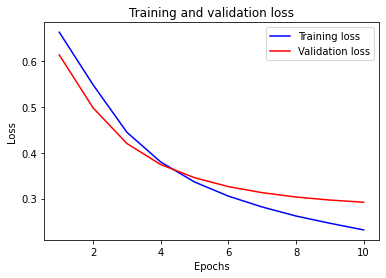

In [38]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')

plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

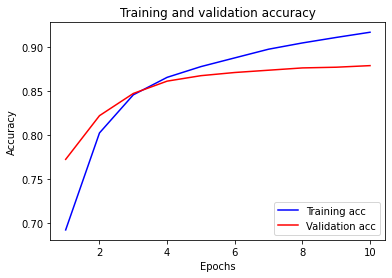

In [39]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [40]:
#In this model, we add vectorize_layer to the model.

export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

In [41]:
export_model.compile(
   loss=losses.BinaryCrossentropy(from_logits=False),     
      optimizer="adam", metrics=['accuracy'])

In [42]:
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)


782/782 [==============================] - 8s 10ms/step - loss: 0.3102 - accuracy: 0.8734
0.8733999729156494


# HERE IS THE FIRST RESULT OF THE TASK

In [43]:
sentiment = export_model.predict(data_csv ['content'])

In [44]:
data_csv['sentiment'] = sentiment[:,0]

In [45]:
data_csv.head()

,content,label,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,0.585095
1,OK... so... I really like Kris Kristofferson a...,0,0.000217
2,"***SPOILER*** Do not read this, if you think a...",0,0.004268
3,hi for all the people who have seen this wonde...,1,0.929629
4,"I recently bought the DVD, forgetting just how...",0,0.559753


In [46]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   content    50000 non-null  object 
 1   label      50000 non-null  int64  
 2   sentiment  50000 non-null  float32
dtypes: float32(1), int64(1), object(1)
memory usage: 976.7+ KB


In [47]:
data_csv_original = data_csv

In [48]:
data_csv['content'] = data_csv['content'].astype("string")
data_csv['label'] = data_csv['label'].astype("string")
data_csv['sentiment'] = data_csv['sentiment'].astype("string") #just converting the values

In [49]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   content    50000 non-null  string
 1   label      50000 non-null  string
 2   sentiment  50000 non-null  string
dtypes: string(3)
memory usage: 1.1 MB


In [50]:
data_csv.head()

,content,label,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,0.58509475
1,OK... so... I really like Kris Kristofferson a...,0,0.0002168606
2,"***SPOILER*** Do not read this, if you think a...",0,0.004267837
3,hi for all the people who have seen this wonde...,1,0.9296293
4,"I recently bought the DVD, forgetting just how...",0,0.5597525


In [51]:
#Create PySpark SparkSession
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()
#Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(data_csv) 

In [52]:
sparkDF.printSchema() 

#Here is our database Schema. We use pyspark instead of DataFrame because DataFrame has not printSchema attribute 

root
 |-- content: string (nullable = true)
 |-- label: string (nullable = true)
 |-- sentiment: string (nullable = true)



# THIRD QUESTION
*2- Design a tokenizer for content column and remove stop words, and give descriptive information about obtained content column
_______

In [3]:
# SECOND QUESTIONS STARTS HERE...

In [53]:
# remove stop words, we need to ntlk lib and stopwords. (Natural Language Toolkit)
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aytek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
aclImdb_question3_part2 = pd.read_csv('aclImdb_question3.csv')

In [55]:
aclImdb_question3_part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  50000 non-null  object
 1   label    50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [56]:
aclImdb_question3_part2.head()

,content,label
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [58]:
# remove the stop words form content column and append our table

aclImdb_question3_part2['without_stopwords'] = aclImdb_question3_part2['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [59]:
aclImdb_question3_part2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   content            50000 non-null  object
 1   label              50000 non-null  int64 
 2   without_stopwords  50000 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [60]:
aclImdb_question3_part2.head() #new table and we design a tokenizer for content column (without_stopwords)

,content,label,without_stopwords
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,"In 1974, teenager Martha Moxley (Maggie Grace)..."
1,OK... so... I really like Kris Kristofferson a...,0,OK... so... I really like Kris Kristofferson u...
2,"***SPOILER*** Do not read this, if you think a...",0,"***SPOILER*** Do read this, think watching mov..."
3,hi for all the people who have seen this wonde...,1,hi people seen wonderful movie im sure thet wo...
4,"I recently bought the DVD, forgetting just how...",0,"I recently bought DVD, forgetting much I hated..."


In [61]:
# to give descriptive information about obtained content column ((without_stopwords)),
# we design a model for without_stopwords.

In [62]:
# for fairly comparison, first model's input is content and second model's input is obtained content
# At the end, we compare these model.

# Firstly, our first model is content column.

# Here is libraries.

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# WE DESIGN A MODEL FOR 'content' COLUMN

In [63]:
# we desing a model for content model.

corpus=[]
for text in aclImdb_question3_part2['content']:
  words= [word.lower() for word in word_tokenize(text)]
  corpus.append(words)

from sklearn.model_selection import train_test_split
X = aclImdb_question3_part2['content']
y = aclImdb_question3_part2['label']


X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

tokenizer= Tokenizer(len(corpus))
tokenizer.fit_on_texts(X_train)

X_train= tokenizer.texts_to_sequences(X_train)
X_train= pad_sequences(X_train, maxlen=128, truncating='post', padding= 'post')

X_test= tokenizer.texts_to_sequences(X_test)
X_test= pad_sequences(X_test, maxlen=128, truncating='post', padding= 'post')


le= LabelEncoder()
y_train= le.fit_transform(y_train)
y_test= le.fit_transform(y_test)
#We use LSTM model
model= Sequential()
model.add(Embedding(input_dim=len(corpus), output_dim=100,
                     input_length=128, trainable=True))
model.add(LSTM(100, dropout=0.1, return_sequences=True))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss= 'binary_crossentropy', optimizer='adam',metrics= ['accuracy'])

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          5000000   
                                                                 
 lstm (LSTM)                 (None, 128, 100)          80400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,160,901
Trainable params: 5,160,901
Non-trainable params: 0
_________________________________________________________________


In [65]:
final_model= model.fit(X_train, y_train, epochs=10, batch_size= 64, validation_data=(X_test, y_test))

Epoch 1/10
625/625 [==============================] - 34s 41ms/step - loss: 0.6186 - accuracy: 0.6416 - val_loss: 0.6791 - val_accuracy: 0.5262
Epoch 2/10
625/625 [==============================] - 24s 39ms/step - loss: 0.5729 - accuracy: 0.7043 - val_loss: 0.4405 - val_accuracy: 0.8168
Epoch 3/10
625/625 [==============================] - 24s 39ms/step - loss: 0.3160 - accuracy: 0.8737 - val_loss: 0.3933 - val_accuracy: 0.8475
Epoch 4/10
625/625 [==============================] - 24s 39ms/step - loss: 0.2921 - accuracy: 0.8812 - val_loss: 0.6457 - val_accuracy: 0.6523
Epoch 5/10
625/625 [==============================] - 24s 39ms/step - loss: 0.4381 - accuracy: 0.7936 - val_loss: 0.4014 - val_accuracy: 0.8387
Epoch 6/10
625/625 [==============================] - 24s 39ms/step - loss: 0.1683 - accuracy: 0.9410 - val_loss: 0.3954 - val_accuracy: 0.8332
Epoch 7/10
625/625 [==============================] - 25s 39ms/step - loss: 0.1504 - accuracy: 0.9473 - val_loss: 0.5121 - val_accuracy:

In [66]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.7208 - accuracy: 0.8292


[0.7207863330841064, 0.829200029373169]

In [88]:
history_dict = final_model.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [89]:
acc2 = history_dict['accuracy']
val_acc2 = history_dict['val_accuracy']
loss2 = history_dict['loss']
val_loss2 = history_dict['val_loss']

# PLOT THE RESULTS of MODEL CONTENT

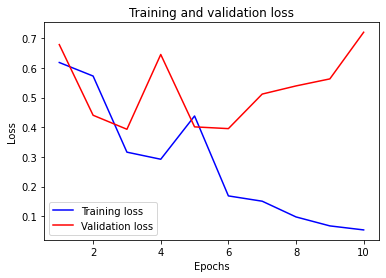

In [107]:
epochs = range(1, len(acc2) + 1)
# "bo" mavi noktalar için
plt.plot(epochs, loss2, 'b', label='Training loss')
# b düz çizgi için
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss of Content')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

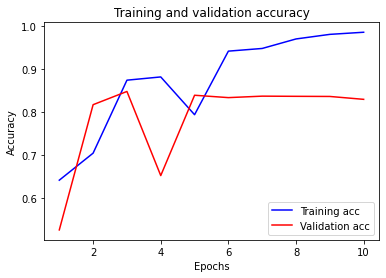

In [108]:
plt.plot(epochs, acc2, 'b', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy of Content')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# WE DESIGN A MODEL FOR 'without_stopwords' COLUMN

In [111]:
# we desing a model for without_stopwords model.

corpus1=[]
for text in aclImdb_question3_part2['without_stopwords']:
  words= [word.lower() for word in word_tokenize(text)]
  corpus1.append(words)

from sklearn.model_selection import train_test_split
X1 = aclImdb_question3_part2['without_stopwords']
y1 = aclImdb_question3_part2['label']


X_train1, X_test1, y_train1, y_test1= train_test_split(X1,y1, test_size=0.2, random_state=42)

tokenizer1 = Tokenizer(len(corpus1))
tokenizer1.fit_on_texts(X_train1)

X_train1 = tokenizer1.texts_to_sequences(X_train1)
X_train1 = pad_sequences(X_train1, maxlen=128, truncating='post', padding= 'post')

X_test1 = tokenizer.texts_to_sequences(X_test1)
X_test1 = pad_sequences(X_test1, maxlen=128, truncating='post', padding= 'post')


le1 = LabelEncoder()
y_train1= le1.fit_transform(y_train1)
y_test1= le1.fit_transform(y_test1)
#We use LSTM model
model2 = Sequential()
model2.add(Embedding(input_dim=len(corpus1), output_dim=100,
                     input_length=128, trainable=True))
model2.add(LSTM(100, dropout=0.1, return_sequences=True))
model2.add(LSTM(100, dropout=0.1))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss= 'binary_crossentropy', optimizer='adam',metrics= ['accuracy'])

In [112]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 128, 100)          5000000   
                                                                 
 lstm_2 (LSTM)               (None, 128, 100)          80400     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,160,901
Trainable params: 5,160,901
Non-trainable params: 0
_________________________________________________________________


In [113]:
final_model2= model2.fit(X_train1, y_train1, epochs=10, batch_size= 64, validation_data=(X_test1, y_test1))

Epoch 1/10
625/625 [==============================] - 28s 41ms/step - loss: 0.5682 - accuracy: 0.7030 - val_loss: 0.8838 - val_accuracy: 0.5054
Epoch 2/10
625/625 [==============================] - 25s 39ms/step - loss: 0.5899 - accuracy: 0.6874 - val_loss: 0.7447 - val_accuracy: 0.5021
Epoch 3/10
625/625 [==============================] - 25s 39ms/step - loss: 0.6397 - accuracy: 0.6376 - val_loss: 0.8124 - val_accuracy: 0.4953
Epoch 4/10
625/625 [==============================] - 25s 39ms/step - loss: 0.4204 - accuracy: 0.8084 - val_loss: 1.1911 - val_accuracy: 0.4655
Epoch 5/10
625/625 [==============================] - 24s 39ms/step - loss: 0.1918 - accuracy: 0.9303 - val_loss: 1.4767 - val_accuracy: 0.4760
Epoch 6/10
625/625 [==============================] - 24s 39ms/step - loss: 0.0994 - accuracy: 0.9685 - val_loss: 1.7137 - val_accuracy: 0.4721
Epoch 7/10
625/625 [==============================] - 25s 39ms/step - loss: 0.0521 - accuracy: 0.9863 - val_loss: 2.0139 - val_accuracy:

In [114]:
model2.evaluate(X_test1, y_test1)

313/313 [==============================] - 3s 9ms/step - loss: 2.4694 - accuracy: 0.4742


[2.469374418258667, 0.4742000102996826]

In [115]:
history_dict2 = final_model2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [118]:
acc3 = history_dict2['accuracy']
val_acc3 = history_dict2['val_accuracy']
loss3 = history_dict2['loss']
val_loss3 = history_dict2['val_loss']

# PLOT THE RESULTS of MODEL without_stopwords

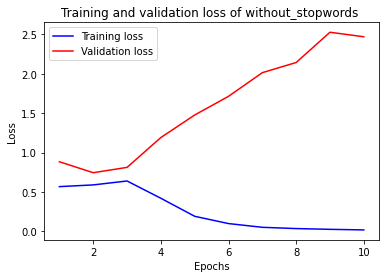

In [119]:
epochs = range(1, len(acc3) + 1)

plt.plot(epochs, loss3, 'b', label='Training loss')

plt.plot(epochs, val_loss3, 'r', label='Validation loss')
plt.title('Training and validation loss of without_stopwords ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

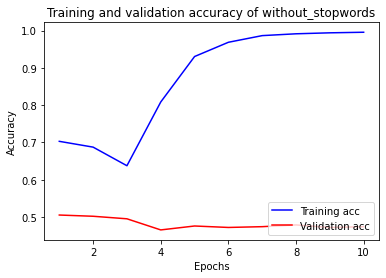

In [120]:
plt.plot(epochs, acc3, 'b', label='Training acc')
plt.plot(epochs, val_acc3, 'r', label='Validation acc')
plt.title('Training and validation accuracy of without_stopwords')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [121]:
# FINISH TASK.

# COMPARISION THE 'CONTENT' and 'without_stopwords' model

In [122]:
# give descriptive information about obtained content column

# When we examine this loss and accuracy graphes of two model, all validation loss are increasing both models.

# That means, these models have overfitting problem. In order to overcome this problem
# we have to change the model, stop the training process early.

# When we examine the accuracy values, training acc values are increasing but validation acc values are not like training acc.
# That means our model memorize this data. 

# Also without_stopwords acc value are greater than normal model because in without_stopwords set, we do not have stop words.


# for 'without_stopwords' model

# We better accuracy, loss for training but validation result is not appropriate. This problem is called overfitting.
# We change the model or stop the early training or we change the data for training set.